# Interpret NLP model by Captum

In [1]:
import pandas as pd
from underthesea import word_tokenize, sent_tokenize, text_normalize
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from captum.attr import  LayerIntegratedGradients, visualization as viz, LayerConductance
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


class Colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


device = 'cpu'
print(device)

cpu


## 1. Input Data

In [2]:
df = pd.read_feather('data/facebook_comments.ftr')

# labels
labels = df['sentiment'].unique().tolist()
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}
print(f'label: {id2label}')

df['label'] = df['sentiment'].map(label2id)
df.drop(columns=['sentiment'], inplace=True)

label: {0: 'positive', 1: 'negative'}


In [3]:
def apply_word_tokenize(sen):
    sen = " ".join(sen.split())
    sens = sent_tokenize(sen)
    tokenized_sen = []
    for sen in sens:
        tokenized_sen += word_tokenize(text_normalize(sen))
    return ' '.join(['_'.join(words.split(' ')) for words in tokenized_sen])


df['token'] = df['content'].map(lambda x: apply_word_tokenize(x.lower()))
df.drop(columns=['content'], inplace=True)
df.head()

,label,token
0,0,mình cần mua xúc_xích cho chó nên mình đặt và ...
1,1,"mệt_mỏi quá mọi người ơi . j & t , ghn dừng nh..."
2,0,mấy ac nào mà giờ con ham gửi hàng thì chuẩn_b...
3,0,tình_hình kho pi exress - bưu_cục chi_nhánh ch...
4,1,🛑 tất_cả đơn_vị vận_chuyển shopee đã được bật ...


## 2. Explanation

### 2.1 LayerIntegratedGradients

There are two different ways of computing the attributions for embedding layers. 
1. Use LayerIntegratedGradients and compute the attributions with respect to BertEmbedding. 
2. Use LayerIntegratedGradients for each word_embeddings and compute the attributions each embedding.

In [4]:
pretrain_name = "phobert/sentiment"
tokenizer = AutoTokenizer.from_pretrained(pretrain_name)
model = AutoModelForSequenceClassification.from_pretrained(pretrain_name, num_labels=len(labels), id2label=id2label, label2id=label2id)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

**Word_embeddings** is a matrix of shape (64001, 768) where the first dimension is the vocabulary dimension, while the second is embedding dimension, i.e. the number of features with which we represent a word. For base-bert it’s 768 and it increases for bigger models. In general the higher the embedding dimension the better we can represent certain words — this is true to a degree, at some point increasing the dimension will not increase the accuracy of the model by much while computational complexity does.

In [5]:
model.roberta.embeddings.word_embeddings.weight.shape

torch.Size([64001, 768])

**Position_embeddings** is a matrix of shape (256, 768) where the former represents the max sentence length whilst the latter is the features dimension as for word embeddings — so depending on the position of each token we retrieve the associated vector.

In [6]:
model.roberta.embeddings.position_embeddings.weight.shape

torch.Size([258, 768])

**Token_type_embeddings** is “redundant” here and comes from the Bert training task where the semantic similarity between two sentences is assessed — this embedding is needed to distinguish between the first and the second sentence. We do not need it as we have only one input sentence for classification task.

In [7]:
model.roberta.embeddings.token_type_embeddings

Embedding(1, 768)

In [8]:
class XAI:
    def __init__(self, text_, label_, tokenizer_, model_, device_):
        self.text = text_
        self.label = label_
        self.tokenizer = tokenizer_
        self.model = model_
        self.ref_token_id = self.tokenizer.pad_token_id
        self.sep_token_id = self.tokenizer.sep_token_id
        self.cls_token_id = self.tokenizer.cls_token_id
        self.device = device_
        self.input_ids = None
        self.ref_input_ids = None

    def construct_input_ref(self):
        text_ids = self.tokenizer.encode(self.text, add_special_tokens=False)
        input_ids = [self.cls_token_id] + text_ids + [self.sep_token_id]
        ref_input_ids = [self.cls_token_id] + [self.ref_token_id] * len(text_ids) + [self.sep_token_id]

        self.input_ids = torch.tensor([input_ids], device=device)
        self.ref_input_ids = torch.tensor([ref_input_ids], device=device)

        return self.input_ids, self.ref_input_ids

    def custom_forward(self, inputs):
        # return torch.softmax(self.model(inputs)[0], dim=1)[0]  # multi-class
        return torch.sigmoid(self.model(inputs)[0])[0]  # binary

    def visualize(self):
        self.input_ids, self.ref_input_ids = self.construct_input_ref()
        self.all_tokens = tokenizer.convert_ids_to_tokens(self.input_ids[0])

        lig = LayerIntegratedGradients(self.custom_forward, self.model.roberta.embeddings)
        attributions, delta = lig.attribute(inputs=self.input_ids,
                                            baselines=self.ref_input_ids,
                                            n_steps=500,
                                            internal_batch_size=3,
                                            return_convergence_delta=True)

        attributions = attributions.sum(dim=-1).squeeze()
        attributions_sum = attributions / torch.norm(attributions)

        score_bert = self.custom_forward(self.input_ids)
        prod_pred = score_bert.max()
        class_pred = score_bert.argmax()

        print(f'{Colors.OKCYAN}Text:{Colors.ENDC} {text} \n'
              f'{Colors.OKCYAN}Predicted Probability:{Colors.ENDC} {prod_pred:,.2f}\n'
              f'{Colors.OKCYAN}Predicted Class:{Colors.ENDC} {class_pred} '
              f'({id2label[class_pred.item()]}) vs. True Class: {self.label} ({id2label[self.label]})')

        score_vis = viz.VisualizationDataRecord(attributions_sum,
                                                pred_prob=prod_pred,
                                                pred_class=class_pred,
                                                true_class=self.label,
                                                attr_class=class_pred,
                                                attr_score=attributions_sum.sum(),
                                                raw_input_ids=self.all_tokens,
                                                convergence_score=delta)

        viz.visualize_text([score_vis])
        return attributions_sum

        
    def get_topk_attributed_tokens(self, attrs, k=5):
        values, indices = torch.topk(attrs, k)
        top_tokens = [self.all_tokens[idx] for idx in indices]
        return pd.DataFrame({'Word': top_tokens, 'Index': indices, 'Attribution': values})

In [9]:
report = pd.DataFrame()
for i in [1, 3, 4]:
    text = df['token'].values[i]
    label = df['label'].values[i]
    explain = XAI(text, label, tokenizer, model, device)
    attributions_sum = explain.visualize()
    
    df_topk = explain.get_topk_attributed_tokens(attributions_sum)
    df_topk['Text'] = text
    report = pd.concat([report, df_topk])
    
    print(10*'=')

Text: mệt_mỏi quá mọi người ơi . j & t , ghn dừng nhận hàng , đơn bị hủy , trả về mà chán luôn . lý_do : mặt_hàng_không thiết_yếu nên ngừng nhận 😭 
Predicted Probability: 0.86
Predicted Class: 1 (negative) vs. True Class: 1 (negative)


Text: tình_hình kho pi exress - bưu_cục chi_nhánh chứ kho tổng ace tự hiểu nhé 😆 
Predicted Probability: 0.88
Predicted Class: 0 (positive) vs. True Class: 0 (positive)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.88),0,-0.48,#s tình_hình kho pi ex@@ ress - bưu_cục chi_nhánh chứ kho tổng ace tự hiểu nhé #unk #/s


Text: 🛑 tất_cả đơn_vị vận_chuyển shopee đã được bật ._shopee lo_lắng các xốp không giao được hàng nên đã tốt_bụng tự bật tất_cả đơn_vị vận_chuyển lên . 😁 ____# hóng 
Predicted Probability: 0.53
Predicted Class: 1 (negative) vs. True Class: 1 (negative)


See top 5 attribution results from all three embedding

In [10]:
report

,Word,Index,Attribution,Text
0,thiết_yếu,33,0.098998,"mệt_mỏi quá mọi người ơi . j & t , ghn dừng nh..."
1,nên,34,0.011480,"mệt_mỏi quá mọi người ơi . j & t , ghn dừng nh..."
2,y,21,0.011246,"mệt_mỏi quá mọi người ơi . j & t , ghn dừng nh..."
3,mọi,3,0.001931,"mệt_mỏi quá mọi người ơi . j & t , ghn dừng nh..."
4,người,4,0.001448,"mệt_mỏi quá mọi người ơi . j & t , ghn dừng nh..."
0,pi,3,0.476073,tình_hình kho pi exress - bưu_cục chi_nhánh ch...
1,nhé,15,0.177847,tình_hình kho pi exress - bưu_cục chi_nhánh ch...
2,kho,2,0.143158,tình_hình kho pi exress - bưu_cục chi_nhánh ch...
3,tổng,11,0.125761,tình_hình kho pi exress - bưu_cục chi_nhánh ch...
4,chứ,9,0.088559,tình_hình kho pi exress - bưu_cục chi_nhánh ch...


## 2.2 LayerConductance - Hidden Layers

We will look into the distribution of attribution scores for each token across all layers in PhoBERT model by `Layer Conductance`

In [11]:
def forward_func2(inputs):
    return model(inputs_embeds=inputs)[0].max(1).values


sep_token_id = tokenizer.sep_token_id
cls_token_id = tokenizer.cls_token_id

text_ids = tokenizer.encode(text, add_special_tokens=False)
input_ids = [cls_token_id] + text_ids + [sep_token_id]
input_ids = torch.tensor([input_ids], device=device)
all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

layer_attr = []
layer_attr_dist = defaultdict(list)

interpretable_embedding = model.roberta.embeddings.word_embeddings
input_embeddings = interpretable_embedding(input_ids)

num_hidden_layers = model.roberta.config.num_hidden_layers
for i in tqdm(range(num_hidden_layers)):
    lc = LayerConductance(forward_func2, model.roberta.encoder.layer[i])
    lc_vals = lc.attribute(input_embeddings)
    
    lc_norm = lc_vals.sum(dim=-1).squeeze(0)
    lc_norm = lc_norm / torch.norm(lc_norm)
    lc_norm = lc_norm.cpu().tolist()
    
    layer_attr.append(lc_norm)
    for idx, select_token in enumerate(all_tokens):
        if len(layer_attr_dist[select_token]) == num_hidden_layers:
            pass
        else:
            layer_attr_dist[select_token].append(lc_vals[0, idx, :].cpu().detach().tolist())

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.20it/s]


The plot below represents a heat map of attributions across all layers and tokens. 
- The word `các` gains increasingly high attribution on layer 7. However, in the rest layers that importance is diminishing.

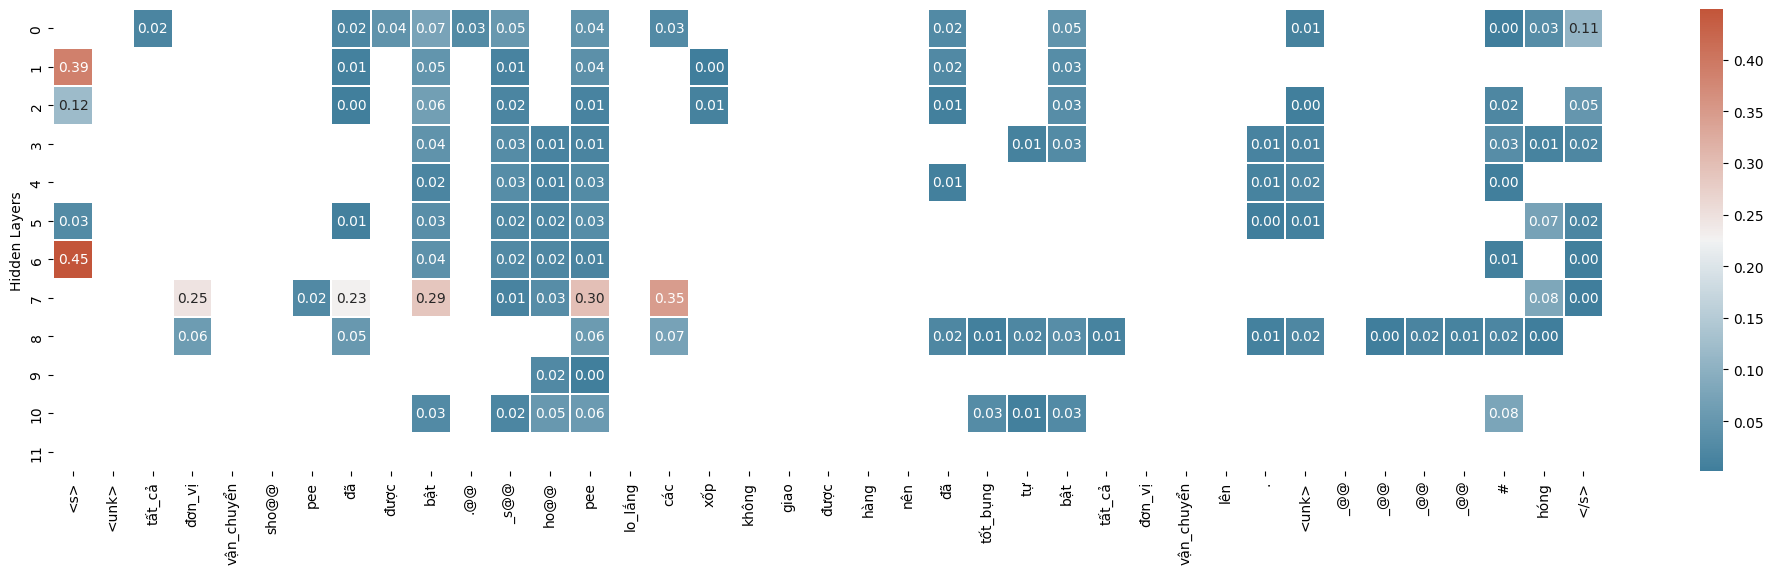

In [12]:
indices = input_ids[0].tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)
data = pd.DataFrame(layer_attr, columns=all_tokens)

plt.figure(figsize=(25, 6))
sns.heatmap(data[data > 0], linewidth=0.2, annot=True, cmap = sns.diverging_palette(230, 20, as_cmap=True), fmt=',.2f')
plt.ylabel('Hidden Layers')
plt.show()

Now let's dig deeper into specific tokens and look into the distribution of attributions per layer for the token. The box plot diagram below shows the presence of outliers especially in the layer 3, 4, ,5 ,6. `không` token dimish at the last layer.

<AxesSubplot: >

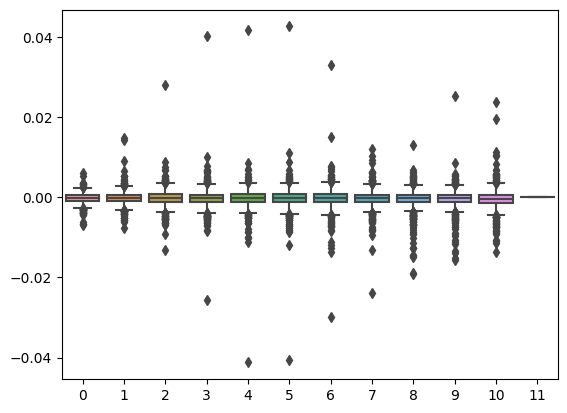

In [13]:
sns.boxplot(data=layer_attr_dist['không'])

`tất_cả` token is still available in all layers.

<AxesSubplot: >

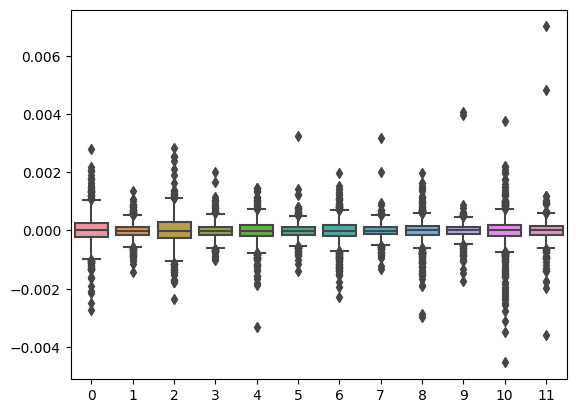

In [14]:
sns.boxplot(data=layer_attr_dist['tất_cả'])